# SQL TEST

## 1.

In [1]:
# select count(*) as completed trips per device, request_at at TIME ZONE 'PST'
# from trips
# where request_at between '12/1/2013 10:00:00 PST' AND '12/8/2013 17:00:00 PST'
# and status = 'completed'
# and city_id = 5
# group by device

## 2.

In [2]:
# select count(distinct trips*), request_at at TIME ZONE 'PST'
# from trips
# join(select userid
#   from users
#   where banned = False
#   and role = 'client') as unbanned_clients
# on unbanned_clients.userid = trips.client_id
# where trips.status = 'completed'
# and city_id = 8
# and request_at between '10/1/2013 00:00:00 PST' AND '10/31/2013 00:00:00 PST'

# BUSINESS QUESTIONS
# PART A

## Experiment / Metrics Design

Problem: Manually filling out earnings on tax forms
Improvement: One tax form with all information automatically filled out

	1. How to Measure (what metric) improvement/success is actual one?
-Faster turn around with forms

	2. Other metric candidate:
-Less errors on forms/filled out correctly
-Less lost forms/destroyed in need of replacement

	3. Experiment design that I could use to confirm hypothesis that my chosen key measure is different in the treated group.
		a. Classic A/B Testing: to confirm hypothesis that chosen key measure is different in treated group/to evaluate treatment effects
		b. Make sure have randomized groups for Control group and Treatment group
		c. When determining Sample Size: Need to make sure it is large enough to yield high statistical power
		d. Data Pre-Processing: 
			i. ratio between control and treatment groups not significantly different 
			ii. Check Metric: What type? This determines hypothesis testing process type
				1) Continuous
				2) Ratio
				3) Proportional
			iii. Outlier Detection/Variance Reduction/Pre-Experiment Bias (Need to be sensitive to these so that they do not pollute dataset)
		e. P-Value Calculation (Significance)
			i. Sample Size can come in different sizes
				1) Skewed
				2) Small
				3) Large
					a) Based on these, there are different tests that are run
						i) T-test
						ii) Chi-Square Test
		f. Lift (see if there is a significant different in treatment group)
		g. Power Calculation performed in order to see the level of confidence in analysis

Some discussion:
Experimental outcomes that constitute success/failure will be based on setting alpha commonly set at 0.05 as the cutoff for significance. If the p-value is <0.05, we reject the null hypothesis that there is no difference between the means and conclude that a significant difference does exist. 

However, what would negatively impact the validity of the experiment would be "network effect". The success of the new feature could simply be due to other reasons outside of treatment group. Validity of A/B tests rest on treatment only affecting behavior of treated users, which is not always the case. 

In order to remedy this, researcher performing experiment could assign treatments randomly based on clusters of users rather than individual users so that network effect is worked against in experiment. 

# PART B

## Data Analysis

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
%matplotlib inline
from scipy import stats
import itertools
import statsmodels.api as sm
import matplotlib
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

In [4]:
EATSFin = pd.read_csv("Exercise.csv")

In [5]:
list(EATSFin)

['Date', 'Vendor Name', 'Country', 'Product', ' Gross Bookings ', ' Fees ']

In [6]:
EATSFin.head()

,Date,Vendor Name,Country,Product,Gross Bookings,Fees
0,1/1/15,Vendor A,Country 1,Product 1,63.34,0.94
1,1/1/15,Vendor A,Country 2,Product 2,39295.41,2169.53
2,1/1/15,Vendor A,Country 3,Product 3,127.25,3.44
3,1/1/15,Vendor A,Country 4,Product 1,4.85,0.11
4,1/1/15,Vendor A,Country 5,Product 4,4734.94,171.13


In [7]:
EATSFin.tail()

,Date,Vendor Name,Country,Product,Gross Bookings,Fees
7906,4/1/16,Vendor A,Country 32,Product 9,29573.34,504.32
7907,4/1/16,Vendor A,Country 27,Product 2,79.98,6.79
7908,4/1/16,Vendor A,Country 37,Product 4,122769.7,8156.34
7909,4/1/16,Vendor A,Country 28,Product 2,167.76,14.24
7910,4/1/16,Vendor A,Country 70,Product 14,23.35,1.12


Some intitial observations:
1. Dataset spans over 13-month period
2. Various Vendors, Countries and Products
3. Huge ranges between rows

In [8]:
EATSFin.describe()

,Date,Vendor Name,Country,Product,Gross Bookings,Fees
count,7911,7911,7907,7911,7911,7911
unique,16,10,78,22,7304,5763
top,4/1/16,Vendor A,Country 2,Product 4,$-,0.02
freq,694,5629,320,1580,238,65


There is obviously something wrong with data format since summary statistics are not being printed out from .describe()

# Data Cleaning

In [9]:
#Checking each column's data type to see what may be cause.
EATSFin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7911 entries, 0 to 7910
Data columns (total 6 columns):
Date                7911 non-null object
Vendor Name         7911 non-null object
Country             7907 non-null object
Product             7911 non-null object
 Gross Bookings     7911 non-null object
 Fees               7911 non-null object
dtypes: object(6)
memory usage: 370.9+ KB


Bingo! The column types are non-null objects.

Need to change the columns with numbers from obj-->numeric

Another thing to notice here is that Country column has 4 rows that are not present since the whole data set technically has 7911 rows.

Before changing data types, need to covert null values to: NaN's.

In [10]:
#Locate all null's aka string -'$-' in Gross Bookings

mask = np.column_stack([EATSFin[' Gross Bookings '].str.contains(r"\$", na=False) for col in EATSFin])
EATSFin.loc[mask.any(axis=1)]

,Date,Vendor Name,Country,Product,Gross Bookings,Fees
281,1/1/15,Vendor F,Country 2,Product 6,$-,160.94
283,1/1/15,Vendor D,Country 2,Product 16,$-,9709.01
359,2/1/15,Vendor D,Country 2,Product 16,$-,6589.98
520,2/1/15,Vendor F,Country 2,Product 6,$-,191.28
643,3/1/15,Vendor D,Country 2,Product 16,$-,7655.64
681,3/1/15,Vendor F,Country 2,Product 6,$-,170.9
950,4/1/15,Vendor F,Country 2,Product 6,$-,139.99
1203,4/1/15,Vendor D,Country 2,Product 16,$-,12426.51
1324,5/1/15,Vendor F,Country 2,Product 6,$-,175.19
1369,5/1/15,Vendor D,Country 2,Product 16,$-,31203.5


## 238 total rows. 238/7911 = 0.0300846922, which is approximately 3% of the data. Will eliminate all these rows since they do not represent significant portion of dataset.

In [11]:
#Locate all null's aka string -'$-' in Fees
mask = np.column_stack([EATSFin[' Fees '].str.contains(r"\$", na=False) for col in EATSFin])
EATSFin.loc[mask.any(axis=1)].head()

,Date,Vendor Name,Country,Product,Gross Bookings,Fees
71,1/1/15,Vendor A,Country 35,Product 12,-2.33,$-
168,1/1/15,Vendor A,Country 19,Product 10,-0.44,$-
192,1/1/15,Vendor D,Country 2,Product 14,585.99,$-
358,2/1/15,Vendor D,Country 2,Product 14,562.81,$-
779,3/1/15,Vendor D,Country 2,Product 14,775.12,$-


In [12]:
mask = np.column_stack([EATSFin[' Fees '].str.contains(r"\$", na=False) for col in EATSFin])
EATSFin.loc[mask.any(axis=1)].count()

Date                51
Vendor Name         51
Country             51
Product             51
 Gross Bookings     51
 Fees               51
dtype: int64

## 51 total rows. 51/7911 = 0.00644671975, which is approximately 0.6% of the data. Can afford to take out all these rows as well.

After dropping rows with '$-', dataframe should be between the size: 7673 and 7622 (assuming there are no character overlaps between 'Gross Bookings' and 'Fees' or character in both columns.

In [13]:
EATSFin[' Gross Bookings '] = pd.to_numeric(EATSFin[' Gross Bookings '], errors='coerce')

In [14]:
#From original data table, entry @ index: 7882, column Gross Bookings was empty and now should be filled with NaN.
EATSFin.iloc[[7882]]

,Date,Vendor Name,Country,Product,Gross Bookings,Fees
7882,4/1/16,Vendor F,Country 2,Product 6,NaN,366.82


Finally- EATSFin[' Gross Bookings '] converted to NaN. Next step is to produce df w/o NaN's.

In [15]:
EATSFin[' Gross Bookings '] = pd.to_numeric(EATSFin[' Gross Bookings '], errors='coerce').dropna()

In [16]:
EATSFin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7911 entries, 0 to 7910
Data columns (total 6 columns):
Date                7911 non-null object
Vendor Name         7911 non-null object
Country             7907 non-null object
Product             7911 non-null object
 Gross Bookings     7673 non-null float64
 Fees               7911 non-null object
dtypes: float64(1), object(5)
memory usage: 370.9+ KB


As expected, ' Gross Bookings ' column reduced to 7673, but need to actually reduce the whole dataframe to that number.

Will extract rows that don't have NaN's. This should produce the desired result.

In [17]:
EATSFin2 = EATSFin[pd.notnull(EATSFin[' Gross Bookings '])]

In [18]:
EATSFin2.head()

,Date,Vendor Name,Country,Product,Gross Bookings,Fees
0,1/1/15,Vendor A,Country 1,Product 1,63.34,0.94
1,1/1/15,Vendor A,Country 2,Product 2,39295.41,2169.53
2,1/1/15,Vendor A,Country 3,Product 3,127.25,3.44
3,1/1/15,Vendor A,Country 4,Product 1,4.85,0.11
4,1/1/15,Vendor A,Country 5,Product 4,4734.94,171.13


Woohoo!!! Dataframe is reduced to 7673! Awesome. Now moving onto eliminating '$-' in 'Fees'

In [19]:
EATSFin2[' Fees '] = pd.to_numeric(EATSFin2[' Fees '], errors='coerce')

In [20]:
#Test to see that rows with '$-' in 'Fees' column converted to NaN
#From original data table, entry @ index: 71, column Fees was empty and now should be filled with NaN.
EATSFin2.iloc[[71]]

,Date,Vendor Name,Country,Product,Gross Bookings,Fees
71,1/1/15,Vendor A,Country 35,Product 12,-2.33,NaN


Yes! Now extract all rows from EATSFin that do not have NaN

In [21]:
EATSFin3 = EATSFin2[pd.notnull(EATSFin2[' Fees '])]

In [22]:
EATSFin3.head()

,Date,Vendor Name,Country,Product,Gross Bookings,Fees
0,1/1/15,Vendor A,Country 1,Product 1,63.34,0.94
1,1/1/15,Vendor A,Country 2,Product 2,39295.41,2169.53
2,1/1/15,Vendor A,Country 3,Product 3,127.25,3.44
3,1/1/15,Vendor A,Country 4,Product 1,4.85,0.11
4,1/1/15,Vendor A,Country 5,Product 4,4734.94,171.13


Great! As expected, EATSFin without rows with '$-' would be >= 7622 and <7673 remaining rows. And 7639 is right in between. =)

Now, we want to see if .describe works with transformed datatypes and eliminated NaN's to see distribution of values.

In [23]:
EATSFin3.describe()

,Gross Bookings,Fees
count,7.639000e+03,7.639000e+03
mean,4.445231e+05,1.551625e+04
std,3.109744e+06,1.234557e+05
min,-2.701010e+03,-2.900000e-01
25%,7.562000e+01,3.105000e+00
50%,2.483660e+03,1.050200e+02
75%,3.970618e+04,1.363080e+03
max,6.873661e+07,6.135380e+06


Yes! Now, we can go ahead and eliminate any outliers. In order to better see that data, we can boxplot these columns to visualize those points that are far from the main cluster.

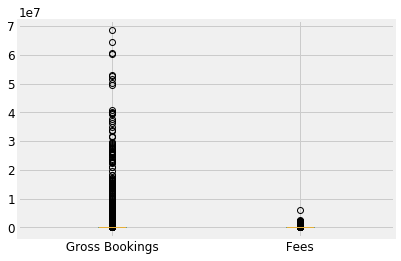

In [24]:
boxplot = EATSFin3.boxplot(column=[' Gross Bookings ', ' Fees '])

Based on this, it looks like there is a greater spread in ' Gross Bookings '. Outliers will be removed since this is  regression problem. Accurate regressions need to have outliers eliminated.

We will use zcore to drop outliers. Zscore: In this procedure, z-score is calculated for each observation. Any z-score greater than 3 or less than -3 is considered to be an outlier. This rule of thumb is based on the empirical rule. From this rule we see that almost all of the data (99.7%) should be within three standard deviations from the mean.

In [25]:
EATSFin4 = EATSFin3[(np.abs(stats.zscore(EATSFin3.drop(['Date', 'Vendor Name', 'Country', 'Product'], 
                                                       axis=1))) < 3).all(axis=1)]

To check that outliers removed:
1. new summary statistics should have max value > max value from previous df that still had outliers. 
2. new boxplot should not have points scattered in remote areas from mean and SD's

In [26]:
EATSFin4.describe()

,Gross Bookings,Fees
count,7.551000e+03,7551.000000
mean,1.614825e+05,6363.368809
std,7.249687e+05,25696.424125
min,-2.701010e+03,-0.290000
25%,7.196000e+01,2.960000
50%,2.284680e+03,97.100000
75%,3.630036e+04,1239.860000
max,8.956605e+06,357333.080000


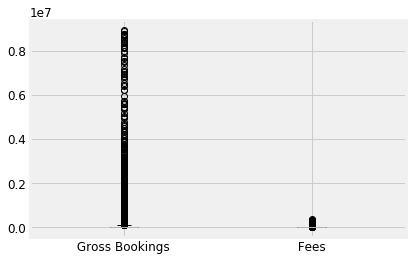

In [27]:
boxplot = EATSFin4.boxplot(column=[' Gross Bookings ', ' Fees '])

Yes, outliers removed! Spread is more compact for Gross Bookings and Fees.

In [28]:
EATSFin4.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7551 entries, 0 to 7910
Data columns (total 6 columns):
Date                7551 non-null object
Vendor Name         7551 non-null object
Country             7547 non-null object
Product             7551 non-null object
 Gross Bookings     7551 non-null float64
 Fees               7551 non-null float64
dtypes: float64(2), object(4)
memory usage: 412.9+ KB


Now, we are going to convert the 'Date' column from non-null object to Python's date time format.

In [29]:
from datetime import datetime
EATSFin4['Date'] =  pd.to_datetime(EATSFin4['Date'],
                              format='%m/%d/%y')

Confirming 'Date' column changed from non-null object to datetime.

In [30]:
EATSFin4.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7551 entries, 0 to 7910
Data columns (total 6 columns):
Date                7551 non-null datetime64[ns]
Vendor Name         7551 non-null object
Country             7547 non-null object
Product             7551 non-null object
 Gross Bookings     7551 non-null float64
 Fees               7551 non-null float64
dtypes: datetime64[ns](1), float64(2), object(3)
memory usage: 412.9+ KB


Yes! Confirmed datetime.

Also confirming float types in order to properly calculate new percentage column.
At this point, need to add new column, "% Gross Bookings" to edited dataframe.

In [31]:
#Need to get total amount from ' Gross Bookings ' to use in new column calculation
gross_sum = EATSFin4[' Gross Bookings '].sum()

In [32]:
gross_sum

1219353980.27

In [33]:
#Creating '% Gross Bookings' column. 
EATSFin4['% Gross Bookings'] = (EATSFin4[' Gross Bookings '] / gross_sum) *100

In [34]:
EATSFin4.head()

,Date,Vendor Name,Country,Product,Gross Bookings,Fees,% Gross Bookings
0,2015-01-01,Vendor A,Country 1,Product 1,63.34,0.94,5.194554e-06
1,2015-01-01,Vendor A,Country 2,Product 2,39295.41,2169.53,3.222642e-03
2,2015-01-01,Vendor A,Country 3,Product 3,127.25,3.44,1.043585e-05
3,2015-01-01,Vendor A,Country 4,Product 1,4.85,0.11,3.977516e-07
4,2015-01-01,Vendor A,Country 5,Product 4,4734.94,171.13,3.883155e-04


I noticed that 'Date' column just got changed. Instead of being month/day/year(2 digits), it has become year(4 digits)-day-month. Need to verify this with tail end of dataframe.

In [35]:
EATSFin4.tail()

,Date,Vendor Name,Country,Product,Gross Bookings,Fees,% Gross Bookings
7906,2016-04-01,Vendor A,Country 32,Product 9,29573.34,504.32,0.002425
7907,2016-04-01,Vendor A,Country 27,Product 2,79.98,6.79,0.000007
7908,2016-04-01,Vendor A,Country 37,Product 4,122769.70,8156.34,0.010068
7909,2016-04-01,Vendor A,Country 28,Product 2,167.76,14.24,0.000014
7910,2016-04-01,Vendor A,Country 70,Product 14,23.35,1.12,0.000002


The 'Date' column has been changed to year(4 digits)-day-month. Keep this in mind as I analyze visualizations.

# Exploratory Data Analysis

After manually inspecting data, suspecting that each month's data may have varying amounts of data. This affects model building as accuracy of model depends on how even data is between dates. Will re-inspect data with date counts to see distribution of data.

In [36]:
EATSFin4_dategroups = EATSFin4.groupby(['Date'])

In [37]:
EATSFin4_dategroups.count()

,Vendor Name,Country,Product,Gross Bookings,Fees,% Gross Bookings
Date,,,,,,
2015-01-01,297,297,297,297,297,297
2015-02-01,304,304,304,304,304,304
2015-03-01,321,321,321,321,321,321
2015-04-01,325,325,325,325,325,325
2015-05-01,350,350,350,350,350,350
2015-06-01,366,366,366,366,366,366
2015-07-01,359,359,359,359,359,359
2015-08-01,475,474,475,475,475,475
2015-09-01,483,482,483,483,483,483


As suspected, distribution of total datasets points is not the same month-to-month. There is a actually growth in datapoint density per month starting with around 300 at the beginning of dataset to doubling to around 600 at the end. At the same time, this is just a count and not a sum of data points.

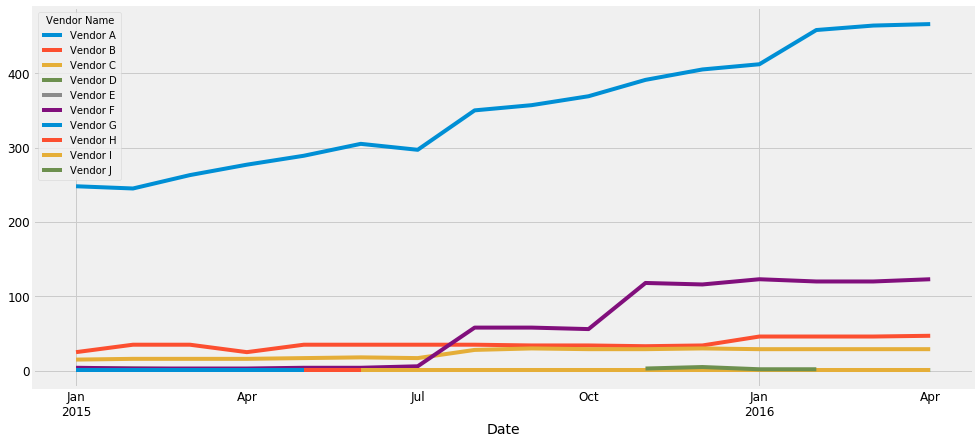

In [38]:
#Vendor Name Groups vs. Time
fig, ax = plt.subplots(figsize=(15,7))

EATSFin4.groupby(['Date','Vendor Name']).count()['% Gross Bookings'].unstack().plot(ax=ax)

Vendor A is way above every other Vendor. And Vendor F is the next highly ranked though there is a huge separation between the two. These two vendors would be worth investing in.

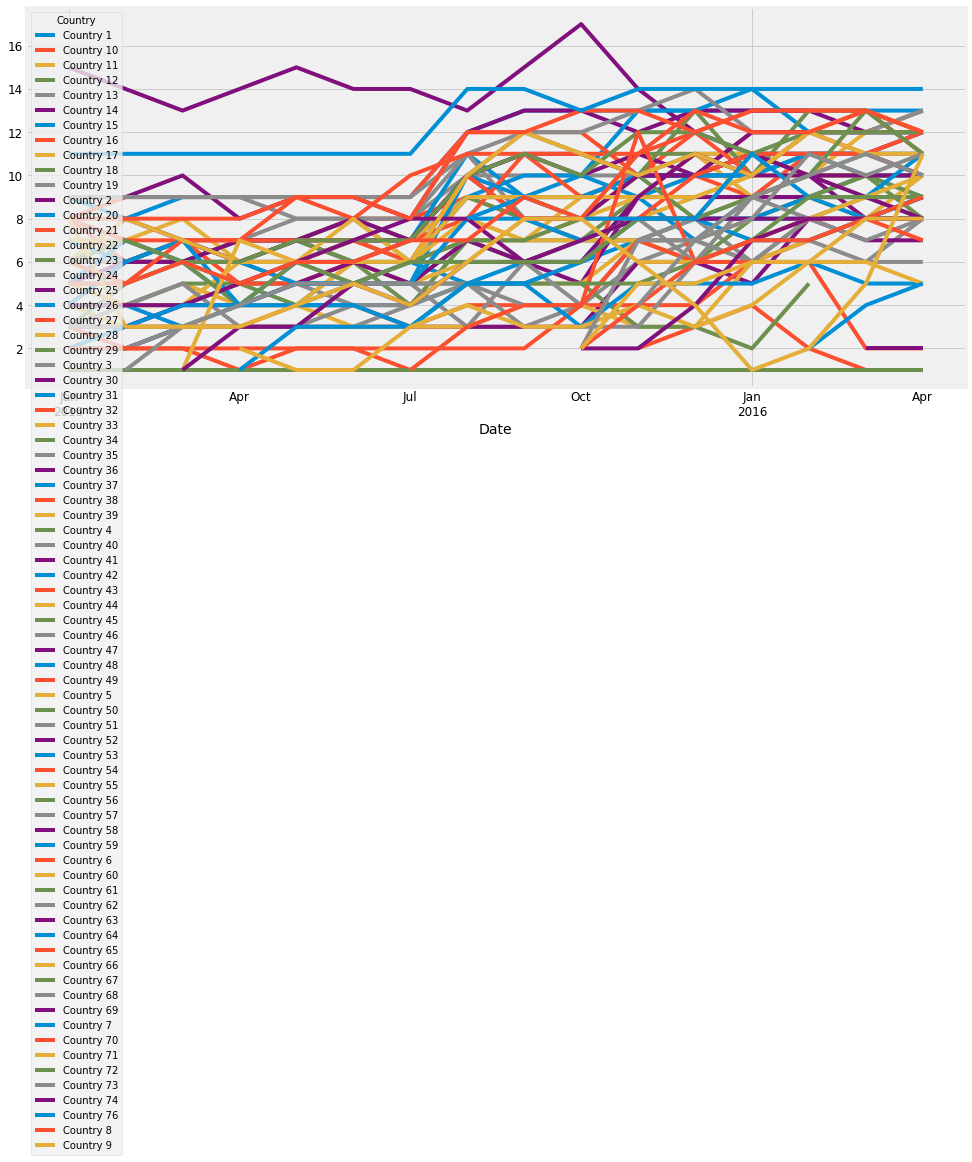

In [39]:
#Country Groups vs. Time
fig, ax = plt.subplots(figsize=(15,7))


EATSFin4.groupby(['Date','Country']).count()['% Gross Bookings'].unstack().plot(ax=ax)

There are differences in how much each country contribute to '% Gross Bookings'. Most countries are above 2 units for '% Gross Bookings'.

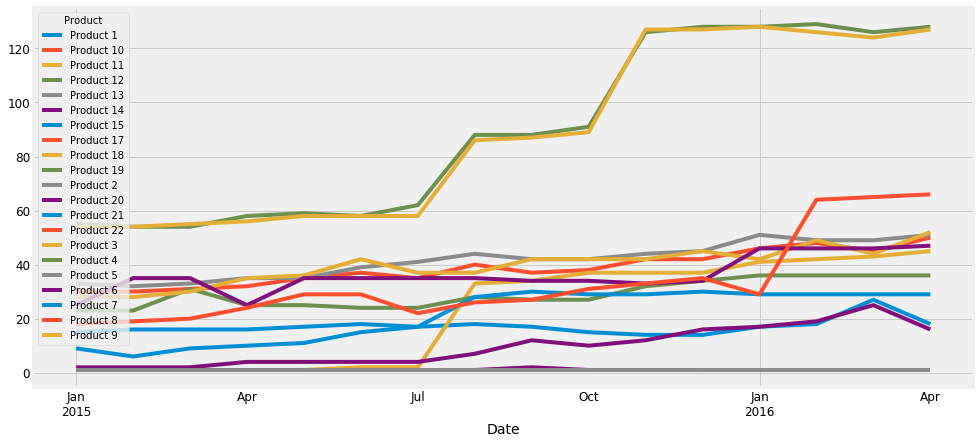

In [40]:
#Product Groups vs. Time
fig, ax = plt.subplots(figsize=(15,7))


EATSFin4.groupby(['Date','Product']).count()['% Gross Bookings'].unstack().plot(ax=ax)

There are two products- 4 and 9 that are doing 3x better than the rest. Maybe a good idea to drop any products below 20 units. Looking at Fees that are tied to these products could strengthen argument to drop these low performing products.

## Categorizing the Problem:
Have labels --> Supervised Learning
## Categorizing by Output:
Output is a # --> Regression

### Model that will be used is:
Linear Regression since computing a continuous value.
Goal is to predict future value of process that has been run.

## Visualizing % Gross Bookings Time Series data

In [41]:
EATSFin4.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7551 entries, 0 to 7910
Data columns (total 7 columns):
Date                7551 non-null datetime64[ns]
Vendor Name         7551 non-null object
Country             7547 non-null object
Product             7551 non-null object
 Gross Bookings     7551 non-null float64
 Fees               7551 non-null float64
% Gross Bookings    7551 non-null float64
dtypes: datetime64[ns](1), float64(3), object(3)
memory usage: 471.9+ KB


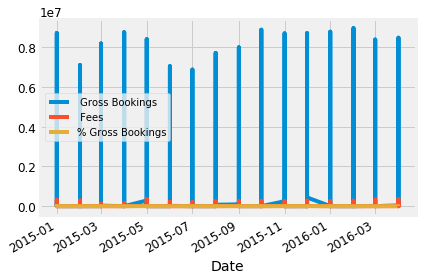

In [42]:
EATSFin4.set_index('Date').plot()

Some things to notice are that within 2015, there are dips in Gross Bookings in Feb, June, July and August. And for 2016, relative to 2015, 2016 has higher Gross Bookings at the beginning of its year.

Fees look even across the graph though this graph is not very granular. The same goes for % Gross Bookings. The values in this column as well as Fees column are very small compared to the values in Gross Bookings column.

There does not seem to show seasonality nor cyclical behavior nor any spikes nor any upper or lower trends across this data that spans over 1.3 years.

# '% Gross Bookings' - univariate without trend nor seasonal components.

In [43]:
#Attempted to use Autoregression model, but result was poor so did not stop exploring other models.

In [44]:
# AR example
from statsmodels.tsa.ar_model import AR
from random import random
# dataset
data = EATSFin4['% Gross Bookings'].values
# fit model
model = AR(data)
model_fit = model.fit()
# make prediction
yhat = model_fit.predict(len(data), len(data))
print(yhat)

[-0.0001137]


In [45]:
(EATSFin4['% Gross Bookings'] < 0).sum()

50

In [46]:
#There are 50 total negative values out of 7551 values. It does not make sense that the prediction is a negative valued %...
#Trying another regression (linear regression)

In [47]:
#Tested out building Linear Regression model. Now time to build real model.

#1. Divide dataset into Training and Test sets
#2. Build model using Training set
#3. Using model, make prediction using Test set date values (2016-04-01)
#4. Validate model by comparing actual Test set y-values to predicted Test set y-values using RMSE values.

In [56]:
#Formatting 'Date' column so that linear regression model can be built.
import datetime as dt

date_col = pd.to_datetime(EATSFin4['Date'])
date_col = date_col.map(dt.datetime.toordinal)

date_col = date_col.values.reshape(-1,1)

In [57]:
#Training Set: Every month except for 2016-04-01.
Tr_x = date_col[:6882]
Tr_y = EATSFin4['% Gross Bookings'][:6882]

In [58]:
#Test Set: Only 2016-04-01 dates.
Te_x = date_col[6882:]
Te_y = EATSFin4['% Gross Bookings'][6882:]

In [59]:
#Build model using Training Set
from sklearn.linear_model import LinearRegression
from sklearn import linear_model

lm = LinearRegression().fit(Tr_x, Tr_y)
lm

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [60]:
#Using model, make prediction using Test set date values (2016-04-01)
lm_Te_predictions =  lm.predict(Te_x)
lm_Te_predictions

array([ 0.01382625,  0.01382625,  0.01382625,  0.01382625,  0.01382625,
        0.01382625,  0.01382625,  0.01382625,  0.01382625,  0.01382625,
        0.01382625,  0.01382625,  0.01382625,  0.01382625,  0.01382625,
        0.01382625,  0.01382625,  0.01382625,  0.01382625,  0.01382625,
        0.01382625,  0.01382625,  0.01382625,  0.01382625,  0.01382625,
        0.01382625,  0.01382625,  0.01382625,  0.01382625,  0.01382625,
        0.01382625,  0.01382625,  0.01382625,  0.01382625,  0.01382625,
        0.01382625,  0.01382625,  0.01382625,  0.01382625,  0.01382625,
        0.01382625,  0.01382625,  0.01382625,  0.01382625,  0.01382625,
        0.01382625,  0.01382625,  0.01382625,  0.01382625,  0.01382625,
        0.01382625,  0.01382625,  0.01382625,  0.01382625,  0.01382625,
        0.01382625,  0.01382625,  0.01382625,  0.01382625,  0.01382625,
        0.01382625,  0.01382625,  0.01382625,  0.01382625,  0.01382625,
        0.01382625,  0.01382625,  0.01382625,  0.01382625,  0.01

In [61]:
#Validate model by comparing actual Test set y-values to predicted Test set y-values using RMSE values.
from sklearn.metrics import mean_squared_error
import numpy as np

lin_mse = mean_squared_error(Te_y, lm_Te_predictions)
Te_lin_rmse = np.sqrt(lin_mse)
Te_lin_rmse

0.056345744412398459

A well-fitting regression model results in predicted values close to the observed data values.
The RMSE is the square root of the variance of the residuals. It indicates the absolute fit of the model to the data–how close the observed data points are to the model’s predicted values.
Lower values of RMSE indicate better fit. RMSE is a good measure of how accurately the model predicts the response, and it is the most important criterion for fit if the main purpose of the model is prediction, which is the case here.

The RMSE value for our model is .06 away from 0, which means that the model predicted the response really well as the result was very close to actual response values from Training set.

In [62]:
# Predictions for May 2016 Based on Model Output

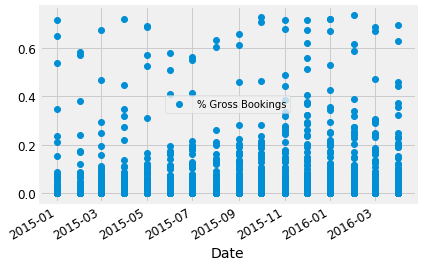

In [63]:
#True data and Predicted data

#TRUE:
EATSFin4.plot(x='Date'[:6882], y='% Gross Bookings'[:6882], style='o')

In [64]:
#PREDICTED:
#So predicted was based on assumption that May 2016 pattern would parallel April 2016 closely since Jan-April 2016 data was 
#very similar based on amount of data points and % Gross Bookings values.
#Build new dataframe first with 2016-05-01 entries, % Gross bookings for that time period and add new predicted values column.

May_2016 = pd.read_csv("May_2016.csv")

In [65]:
May_2016.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 669 entries, 0 to 668
Data columns (total 2 columns):
Date                669 non-null object
% Gross Bookings    0 non-null float64
dtypes: float64(1), object(1)
memory usage: 10.5+ KB


In [66]:
May_2016['Date'] =  pd.to_datetime(May_2016['Date'],
                              format='%m/%d/%Y')

In [67]:
#Check 'Date' column format
May_2016.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 669 entries, 0 to 668
Data columns (total 2 columns):
Date                669 non-null datetime64[ns]
% Gross Bookings    0 non-null float64
dtypes: datetime64[ns](1), float64(1)
memory usage: 10.5 KB


In [68]:
len(lm_Te_predictions)

669

In [69]:
#Confirmed that column and array have same amount of entries. Proceeded with creating a matrix of May 1, 2016 dates 
#and corresponding predictions from model.
May_2016['% Gross Bookings'] = lm_Te_predictions

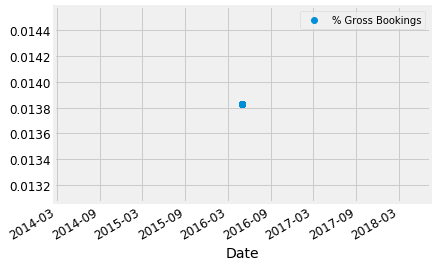

In [70]:
May_2016.plot(x='Date', y='% Gross Bookings', style='o')

Final Discussion:

I chose a simple Linear Regression model because of the % Gross Bookings trend being uniform, non-seasonal, non-cyclical.

If this was not the case, then I would have proceeded with using ARIMA model/ Facebook's Prophet in order to try and build prediction for May 2016 since these applications handle outliers and bends in graph better.

At the same time, I would have analyzed the overall % Gross Bookings differently as well. During EDA, discovered when Vendors and Products were broken up into their respective groups, upper trends, and clear high-performers were detected. And these sort of graphs would prompt Time Series analysis and forecasting with ARIMA and Facebook's Prophet.

Lastly, the original dataset had 'Fees' column. I would have incorporated this in the final analysis to see whether or not it would be worth it to drop Products/Vendors/Countries which incurred high fees and returned low grosses.